In [15]:
import kagglehub
import re
import string
import unidecode
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import spacy
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

pl.Config(fmt_str_lengths=1000, tbl_width_chars=1000);

In [2]:
# Download latest version
kagglehub.config.DEFAULT_CACHE_FOLDER = kagglehub.config.DEFAULT_CACHE_FOLDER.replace("C:", "D:")
path = kagglehub.dataset_download("abdallahwagih/spam-emails")

print("Path to dataset files:", '\\'.join(path.split('\\')[3:]))

Path to dataset files: .cache\kagglehub\datasets\abdallahwagih\spam-emails\versions\1


In [3]:
file_path = path + "\\" + "spam.csv"
df_original = pl.read_csv(source=file_path, separator=",", ignore_errors=True)
df_original.head(15)

Category,Message
str,str
"""ham""","""Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."""
"""ham""","""Ok lar... Joking wif u oni..."""
"""spam""","""Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"""
"""ham""","""U dun say so early hor... U c already then say..."""
"""ham""","""Nah I don't think he goes to usf, he lives around here though"""
…,…
"""ham""","""I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."""
"""spam""","""SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info"""
"""spam""","""URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18"""


In [4]:
df_original.describe()

statistic,Category,Message
str,str,str
"""count""","""5572""","""5572"""
"""null_count""","""0""","""0"""
"""mean""",null,null
"""std""",null,null
"""min""","""ham""","""#ERROR!"""
"""25%""",null,null
"""50%""",null,null
"""75%""",null,null
"""max""","""spam""","""… we r stayin here an extra week, back next wed. How did we do in the rugby this weekend? Hi to and and , c u soon """""


The dataset is formed by 5572 rows and there are not null values.

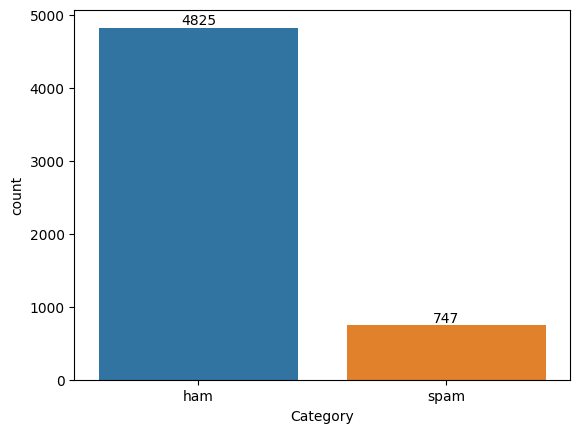

In [5]:
ax = sns.countplot(df_original, x="Category", hue="Category")
for container in ax.containers:
    ax.bar_label(container)

It can be observed that the dataset is pretty unbalanced.

## Clean Data

In [6]:
def remove_accents(text: str) -> str:
    if text:
        return unidecode.unidecode(text)
    return ""

def remove_punctuation_marks(text: str) -> str:
    if text:
        return text.translate(str.maketrans('','',string.punctuation))
    return ""

def text_to_lower_case(text: str) -> str:
    if text:
        return text.lower()
    return ""

def remove_emojis(text: str) -> str:
    if text:
        return text.encode('ascii', 'ignore').decode()
    return ""

def remove_multiple_whitespaces(text: str) -> str:
    if text:
        return re.sub(' +', ' ', text)
    return ""

def remove_text_marks(text: str) -> str:
    if text:
        text=re.sub('\'', '', text)
        text=re.sub(r'[^\w]', ' ', text)
        return text.strip()
    return ""

def remove_alone_numbers(text: str) -> str:
    if text:
        text=re.sub(r'\d', '', text)
        return text
    return ""

def clean_text(text: str) -> str:
    # Apply the different functions in order to clean the text
    text = text_to_lower_case(text)
    text = remove_text_marks(text)
    text = remove_punctuation_marks(text)
    text = remove_accents(text)
    text = remove_emojis(text)
    #text = remove_alone_numbers(text)
    text = remove_multiple_whitespaces(text)
    return text

In [7]:
df_clean_messages = df_original.with_columns(pl.col("Message").map_elements(clean_text))
df_clean_messages.head(5)

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Category,Message
str,str
"""ham""","""go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat"""
"""ham""","""ok lar joking wif u oni"""
"""spam""","""free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry question std txt rate t cs apply 08452810075over18s"""
"""ham""","""u dun say so early hor u c already then say"""
"""ham""","""nah i dont think he goes to usf he lives around here though"""


In [16]:
nlp = spacy.load("en_core_web_trf")

In [17]:
def get_tokens(text: str) -> str:
    my_doc=nlp(text)
    token_list = []
    for token in my_doc:
        token_list.append(token.text)
    return token_list

def remove_stopwords(text: str) -> str:
    token_list=get_tokens(text)
    #Get stop words for the given language
    stopwords_list = stopwords.words('english')
    stopwords_list.remove('no') # If this step is not done, it will remove no from the sentences

    #Create list of word tokens after removing stopwords
    filtered_sentence =[]
    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme not in stopwords_list:
            filtered_sentence.append(word)
    return " ".join(filtered_sentence)

def stem_text(text: str) -> str:
    #Create the stemmer (tip: see the class nltk.stem)
    stemmer = SnowballStemmer('english')

    #Get the tokens
    token_list = get_tokens(text)
    
    #Stem each token in text object
    stemmas = []
    stemmas=[stemmer.stem(token) for token in token_list if token]
    output = " ".join(stemmas)
    return output

In [18]:
def standardize_text(text):
    standardized_text = remove_stopwords(text)
    standardized_text = stem_text(standardized_text)
    return standardized_text


In [19]:
standardized_messages = [standardize_text(text) for text in df_clean_messages["Message"]]

In [20]:
df_standardized = df_clean_messages.with_columns(pl.Series("standardized_messages", standardized_messages))
df_standardized.head(5)

Category,Message,standardized_messages
str,str,str
"""ham""","""go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat""","""go jurong point crazi avail bugi n great world la e buffet cine got amor wat"""
"""ham""","""ok lar joking wif u oni""","""ok lar joke wif u oni"""
"""spam""","""free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry question std txt rate t cs apply 08452810075over18s""","""free entri 2 wkli comp win fa cup final tkts 21st may 2005 text fa 87121 receiv entri question std txt rate cs appli 08452810075over18"""
"""ham""","""u dun say so early hor u c already then say""","""u dun say earli hor u c alreadi say"""
"""ham""","""nah i dont think he goes to usf he lives around here though""","""nah nt think goe usf live around though"""


## Data Preparation

### Encode Categories

In [21]:
# Turn categories into integers
le = LabelEncoder()
encoded_column = pl.Series("category_encoded", le.fit_transform(df_standardized["Category"]))
df = df_standardized.with_columns(encoded_column)
df = df[["standardized_messages", "category_encoded"]]
df.head(5)

standardized_messages,category_encoded
str,i64
"""go jurong point crazi avail bugi n great world la e buffet cine got amor wat""",0
"""ok lar joke wif u oni""",0
"""free entri 2 wkli comp win fa cup final tkts 21st may 2005 text fa 87121 receiv entri question std txt rate cs appli 08452810075over18""",1
"""u dun say earli hor u c alreadi say""",0
"""nah nt think goe usf live around though""",0


### Word Embedding

In [22]:
# Train-Test Split the Dataset
X = df["standardized_messages"]
y = df["category_encoded"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

methodology = "tfidf"

if methodology == "tfidf":
    vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=0.0)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    
elif methodology == "word2vec":
    None
elif methodology == "fasttext":
    None


In [24]:
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier()
rforest.fit(X_train_vectorized,y_train)

RandomForestClassifier()

In [25]:
from sklearn.metrics import classification_report

y_pred = rforest.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.83      0.90       149

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [31]:
total_spam = 0
correct_spam = 0
for i in range(len(y_test)):
    if y_test[i] == 1:
        total_spam += 1
        if y_pred[i] == 1:
            correct_spam += 1

print(f"Total messages: {len(y_test)}")
print(f"Total spam messages: {total_spam}")
print(f"Total spams correctly classified: {correct_spam}")

Total messages: 1115
Total spam messages: 149
Total spams correctly classified: 123


In [32]:
total_no_spam = 0
correct_no_spam = 0
for i in range(len(y_test)):
    if y_test[i] == 0:
        total_no_spam += 1
        if y_pred[i] == 0:
            correct_no_spam += 1
            
print(f"Total messages: {len(y_test)}")
print(f"Total no-spam messages: {total_no_spam}")
print(f"Total no-spams correctly classified: {correct_no_spam}")

Total messages: 1115
Total no-spam messages: 966
Total no-spams correctly classified: 966
